This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



### Preparation

In [1]:
import os
os.chdir("/Users/cherie/Desktop/quantum-gates/src")  # or any folder that actually exists
print(os.getcwd())

/Users/cherie/Desktop/quantum-gates/src


In [2]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import json
import os, sys, importlib
from typing import List
from dotenv import load_dotenv

# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeBrisbane

# 0) Point to the *parent* of the package folder
LOCAL_QG_PATH = r"../src"   # or r"C:\Users\npace\Desktop\quantum-gates\src"
LOCAL_QG_PATH = os.path.abspath(LOCAL_QG_PATH)

# 1) Put local src at the very front of sys.path
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

# 2) Purge any cached copies of the package
for m in list(sys.modules):
    if m == "quantum_gates" or m.startswith("quantum_gates."):
        del sys.modules[m]

# 3) Invalidate import caches and import the local package
importlib.invalidate_caches()
print(os.getcwd())
import quantum_gates

print("Using quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import SurfaceCode
    
    


/Users/cherie/Desktop/quantum-gates/src
Using quantum_gates from: /Users/cherie/Desktop/quantum-gates/src/quantum_gates/__init__.py


In [3]:
code = SurfaceCode(distance=2, cycles=4)

X-stab at qubit 1 (r=0, c=1) -> neighbors [np.int64(4), np.int64(0), np.int64(2)] -> data: [np.int64(4), np.int64(0), np.int64(2)]
X-stab at qubit 7 (r=2, c=1) -> neighbors [np.int64(4), np.int64(6), np.int64(8)] -> data: [np.int64(4), np.int64(6), np.int64(8)]
Z-stab at qubit 3 (r=1, c=0) -> neighbors [np.int64(0), np.int64(6), np.int64(4)] -> data: [np.int64(0), np.int64(6), np.int64(4)]
Z-stab at qubit 5 (r=1, c=2) -> neighbors [np.int64(2), np.int64(8), np.int64(4)] -> data: [np.int64(2), np.int64(8), np.int64(4)]
Parity-check matrix for X stabilizers built.
[[1 1 1 0 0]
 [0 0 1 1 1]]
Parity-check matrix for Z stabilizers built.
[[1 0 1 1 0]
 [0 1 1 0 1]]
Decoder setup complete.


In [4]:
# -------------------------------
# 1️⃣ Setup simulator and initial state
# -------------------------------


sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)
N_q = code.n_data + code.n_stabilizers 

shots = 1
bit_flip_bool = False

# -------------------------------
# 2️⃣ Create and load the fake backend
# -------------------------------

# dump_from_fake_backend.py
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
  # try other Fake*V2 if needed
from quantum_gates.utilities import DeviceParameters

# Pick a fake backend
backend = FakeBrisbane()  # 127 qubits; change to another Fake*V2 if import fails

### Create Circuit

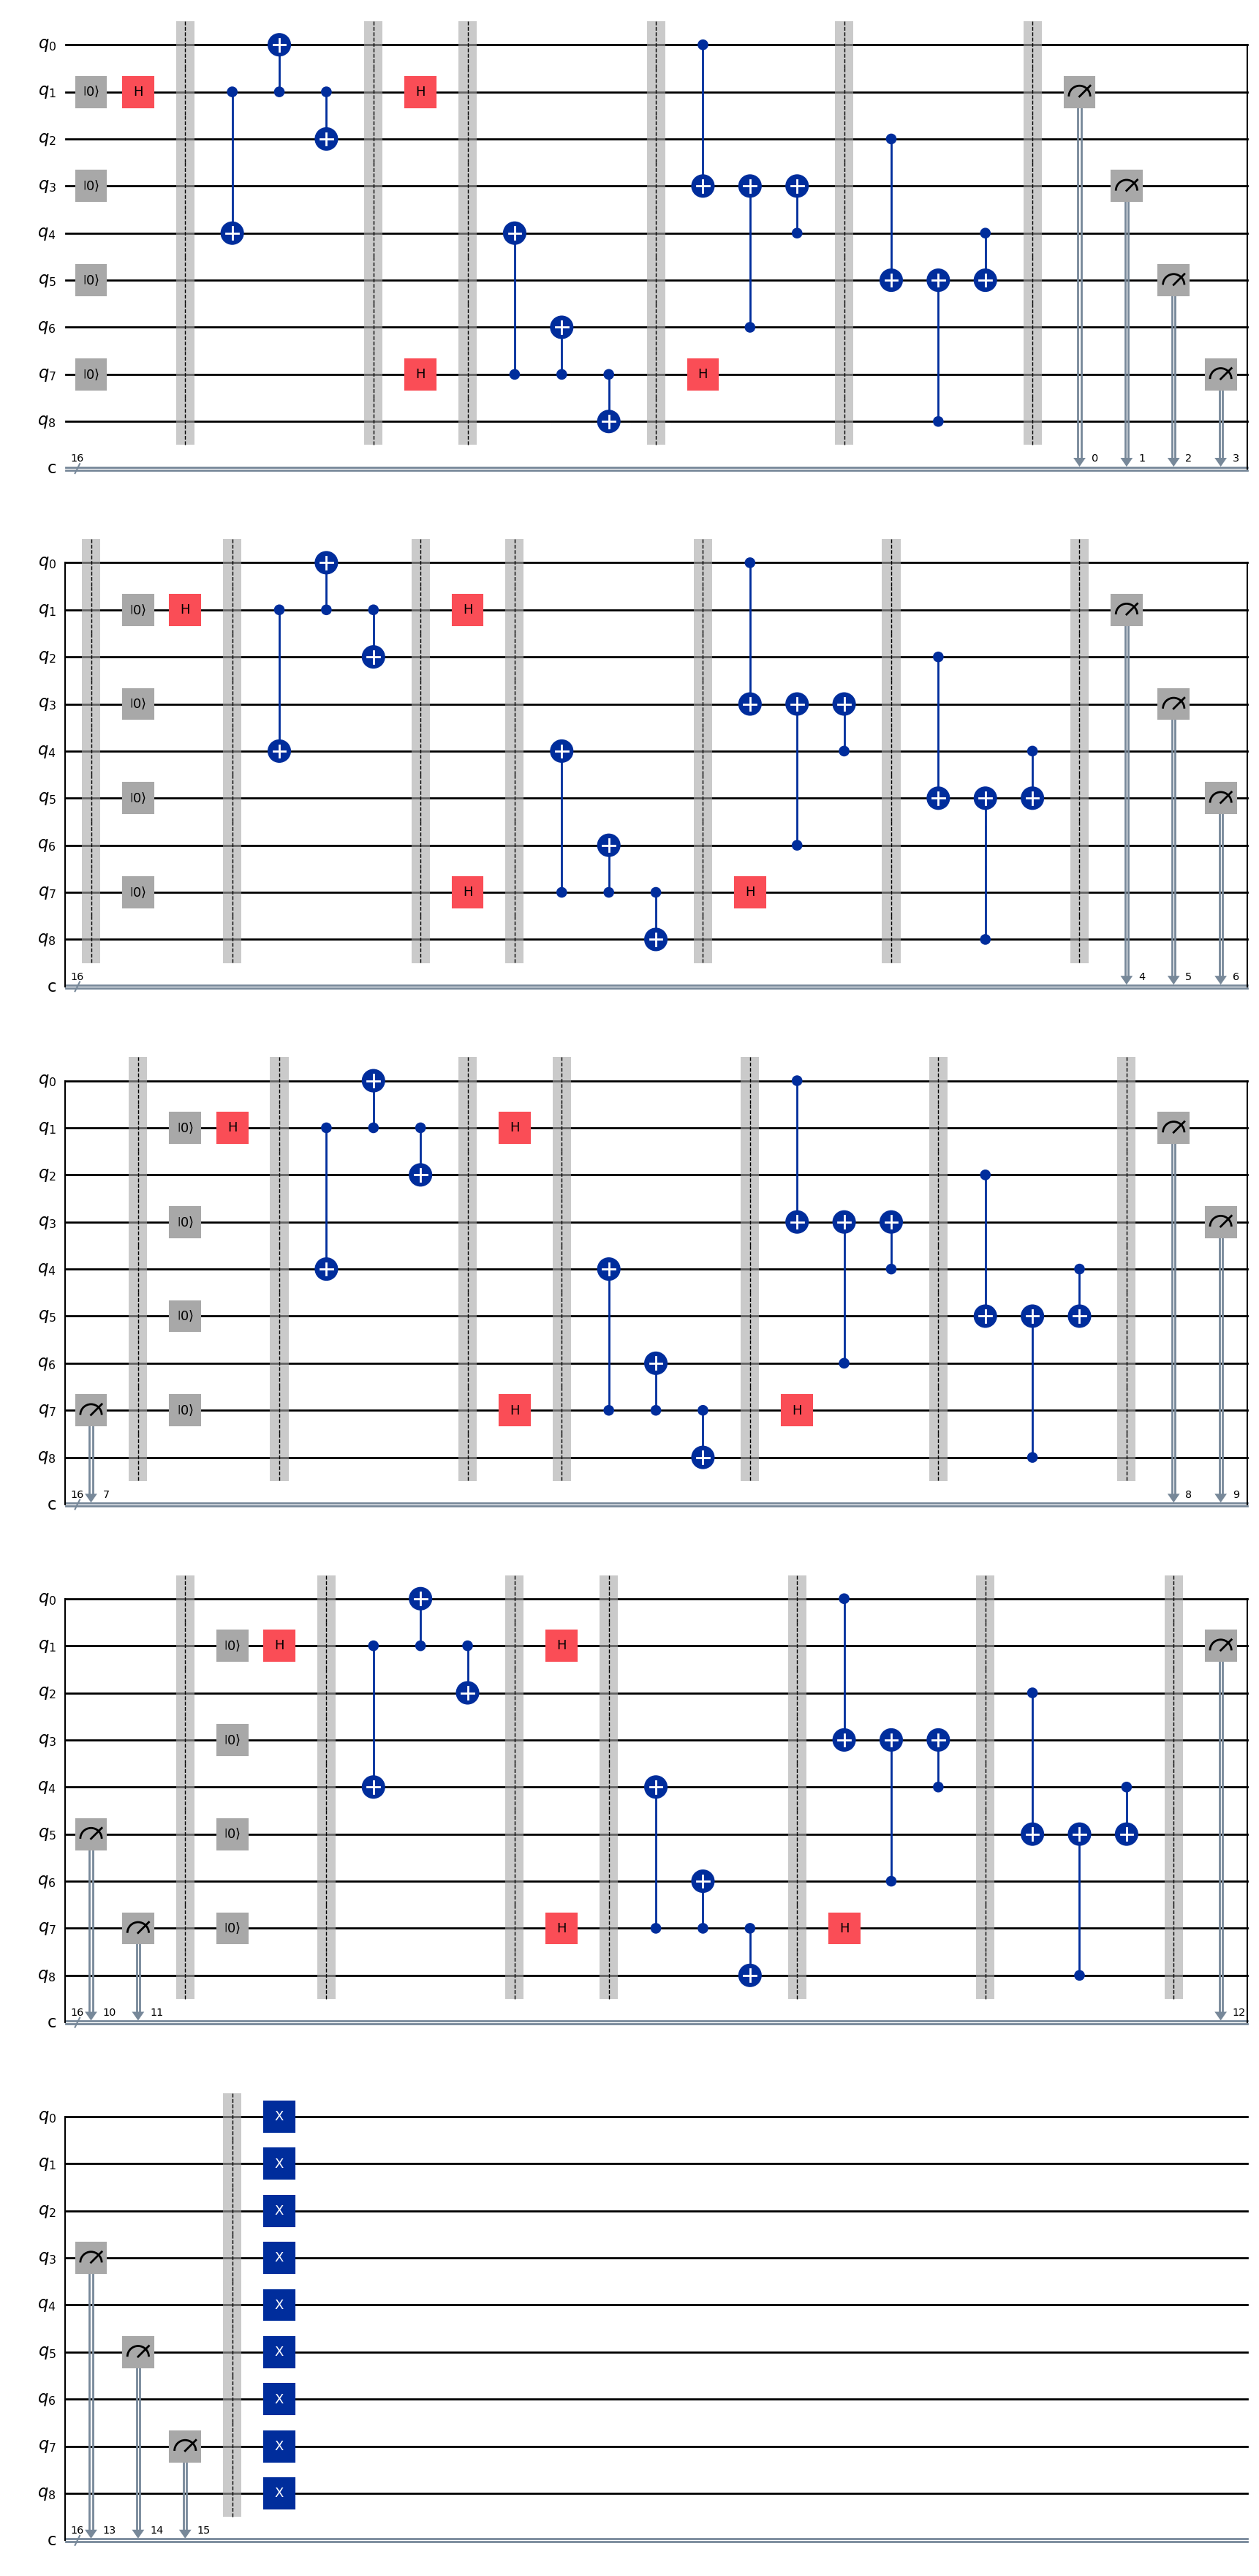

In [5]:

qc = code.qc
qc.x([0,1,2,3,4,5,6,7,8])  # introduce bit-flip errors on all data qubits
qc.draw("mpl")


In [6]:
print(code.n_data + code.n_stabilizers)

print(f"Circuit uses {qc.num_qubits} qubits")


9
Circuit uses 9 qubits


In [7]:
needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=list(range(N_q)),
    seed_transpiler=42,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

#t_circ.draw("mpl")

In [8]:


print(f"Original circuit qubits: {qc.num_qubits}")
print(f"Transpiled circuit qubits: {t_circ.num_qubits}")
print(f"N_q: {N_q}")

# Check which qubits are actually used in transpiled circuit
used_qubits: list[int] = []
for instr in t_circ.data:
    op = instr.operation
    if op.name == 'delay':
        continue
    # support any arity
    for qb in instr.qubits:
        q = qb._index
        if q not in used_qubits:
            used_qubits.append(q)
            
print(f"Qubits used in transpiled circuit: {sorted(used_qubits)}")

max_qubit = max(used_qubits)
nqubit_actual = max_qubit + 1

initial_psi = np.zeros(2**nqubit_actual)

initial_psi[0] = 1.0  # set |00...0⟩

qubits_layout = list(range(nqubit_actual))

#  Load via YOUR class and save JSON next to the script
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()
device_param.save_to_json("./")  # writes ./device_parameters.json
print("Wrote ./device_parameters.json")

res  = sim.run( 
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=initial_psi, 
    shots=shots, 
    device_param=device_param_lookup,
    nqubit=nqubit_actual,
    bit_flip_bool=bit_flip_bool,
    )

probs = res["probs"]
results = res["results"]
num_clbits = res["num_clbits"]
mid_counts = res["mid_counts"]


print("Mid-circuit measurement results", results)
#print("Final measurement counts:", final_counts)
#print("Final measurement probabilities:", probs)
print("Number of classical bits in circuit:", num_clbits)
print("Mid-circuit measurement counts:", mid_counts)

Original circuit qubits: 9
Transpiled circuit qubits: 127
N_q: 9
Qubits used in transpiled circuit: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Device parameters are valid. We can save them. 
Device parameters saved successfully.
Wrote ./device_parameters.json
Inferred nqubit from psi0: 9
Reset on qubit:  1

Reset on qubit:  3

Reset on qubit:  5

Reset on qubit:  7

Reset on qubit:  0

Reset on qubit:  3

Reset on qubit:  5

Reset on qubit:  8

Reset on qubit:  0

Reset on qubit:  3

Reset on qubit:  5

Reset on qubit:  8

Reset on qubit:  0

Reset on qubit:  3

Reset on qubit:  6

Reset on qubit:  8

---- Preprocessed data ----
Chunk 0: delay[0]
Fancy 1: reset_qubits qubits=[1]
Chunk 2: rz[1] , sx[1] , rz[1] , delay[2]
Fancy 3: reset_qubits qubits=[3]
Chunk 4: delay[3] , delay[4]
Fancy 5: reset_qubits qubits=[5]
Chunk 6: delay[5] , delay[6]
Fancy 7: reset_qubits qubits=[7]
Chunk 8: delay[7] , delay[8] , rz[0] , sx[0] , rz[0] , delay[0] , rz[1] , sx[1] , rz[1] , rz[2] , sx[2] , ecr[2, 1] , rz[1] , sx

In [9]:
code._decode_per_cycle([1, 1],[0, 1], which="X")

Correction: X [1 0 0 0 0]


array([1, 0, 0, 0, 0], dtype=uint8)

In [10]:
code.decode_full(mid_counts)

Extracted X syndromes:
 [[0 1]
 [0 1]
 [1 1]
 [1 1]]
Extracted Z syndromes:
 [[1 1]
 [1 1]
 [0 1]
 [1 1]]
Correction: X [0 0 0 0 0]
Correction: Z [0 0 0 0 0]
Correction: X [1 0 0 0 0]
Correction: Z [1 0 0 0 0]
Correction: X [0 0 0 0 0]
Correction: Z [1 0 0 0 0]


(array([[0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=uint8),
 array([[0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]], dtype=uint8))

In [11]:
print("Mid-circuit measurement results", mid_counts)


Mid-circuit measurement results {'1111110111101110': 1}


In [12]:
print(shots)

1


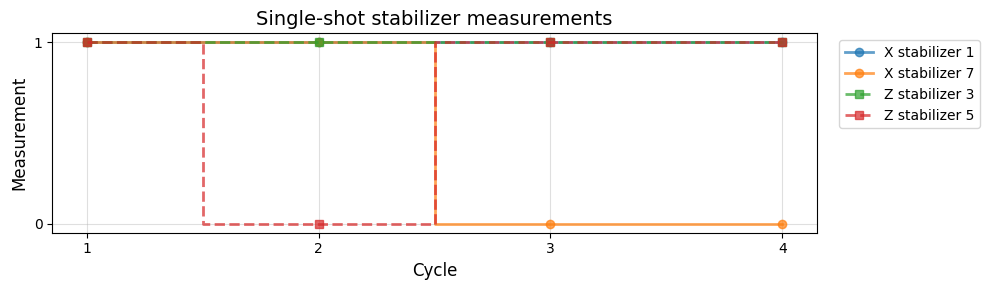

In [13]:
code.plot_results(mid_counts, shots, plot_each_shot=True)



In [14]:
# Simulate with Aer
sim = AerSimulator()
t_qc = transpile(t_circ, sim)
result = sim.run(t_qc, shots=2048).result()
counts = result.get_counts()

CircuitTooWideForTarget: 'Number of qubits (127) in circuit-46 is greater than maximum (30) in the coupling_map'

In [ ]:
t_qc.draw("mpl")    

In [ ]:
print("Aer All clbits counts:", counts)
plot_histogram(counts, title="Aer All classical bits")